# Skip to the end if you want to see summary and final interpretations.

In [41]:
import time
import requests
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [ ]:
# Cell 1: Import libraries and define timestamp function



def get_correct_timestamps():
    """
    Returns start and end timestamps (in seconds) for the last 24 hours.
    """
    now = datetime.utcnow()
    start_time = int((now - timedelta(hours=24)).timestamp())
    end_time = int(now.timestamp())
    return start_time, end_time

# Test the timestamp function
start_time, end_time = get_correct_timestamps()
print("Start Time (sec):", start_time)
print("End Time (sec):", end_time)


Start Time (sec): 1741225527
End Time (sec): 1741311927


C:\Users\kshri\AppData\Local\Temp\ipykernel_20100\4171100383.py:13: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow()


In [4]:
# Cell 2: Fetch trace metadata (IDs) from Tempo using a >1.5s duration filter

def fetch_tempo_traces(base_url, username, password, duration_threshold_ms=1500, limit=100):
    """
    Fetch trace metadata for traces with at least one span exceeding the duration threshold.
    """
    start_time, end_time = get_correct_timestamps()
    params = {
        "query": f'{{span.duration > {duration_threshold_ms}ms}}',  # Filter for >1500ms
        "start": start_time,
        "end": end_time,
        "limit": limit
    }
    
    url = f"{base_url}/api/search"
    print("Fetching traces with parameters:", params)
    
    response = requests.get(url, params=params, auth=(username, password))
    response.raise_for_status()
    data = response.json()
    
    traces = data.get("traces", [])
    df = pd.DataFrame(traces)
    print(f"Fetched {len(df)} traces.")
    return df

# Set your Tempo credentials and base URL
base_url = "https://tempo.aarthy.medblocks.com"
username = "medblocks"
password = "medblocksObsAuth22"

# Fetch the trace metadata
traces_df = fetch_tempo_traces(base_url, username, password)
traces_df.head()


C:\Users\kshri\AppData\Local\Temp\ipykernel_20100\4171100383.py:13: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow()


Fetching traces with parameters: {'query': '{span.duration > 1500ms}', 'start': 1741225578, 'end': 1741311978, 'limit': 100}
Fetched 100 traces.


,traceID,rootServiceName,rootTraceName,startTimeUnixNano,durationMs
0,366d87acae686ee56317eda9c883600,ignite,POST,1741257347965000000,1.0
1,207676803898ed03771b46d1aea385c,ignite,GET,1741257344572000000,39.0
2,2b06b81cc90dfff17e947b360a99b77,ignite,GET,1741257247083000000,158.0
3,6f94467c6f9ab74ebc3e651a6bec51,ignite,POST,1741257226728000000,93.0
4,2683b019cc5c212280b6f6deb69aebf,ignite,POST,1741257225824000000,44.0


In [5]:
traces_df.shape

(100, 5)

In [12]:
# Cell 3: Updated recursive extraction function that calculates duration if needed

def fetch_trace_details(base_url, trace_id, username, password):
    """
    Fetch full trace details for a given trace ID.
    """
    url = f"{base_url}/api/traces/{trace_id}"
    response = requests.get(url, auth=(username, password))
    response.raise_for_status()
    return response.json()

def find_spans_recursive(obj):
    """
    Recursively searches the JSON object for dictionaries that appear to be spans.
    A span is identified if it contains 'spanID' or 'spanId'.
    """
    spans = []
    if isinstance(obj, dict):
        if "spanID" in obj or "spanId" in obj:
            spans.append(obj)
        else:
            for value in obj.values():
                spans.extend(find_spans_recursive(value))
    elif isinstance(obj, list):
        for item in obj:
            spans.extend(find_spans_recursive(item))
    return spans

# Updated extraction function using "startTimeUnixNano" and "endTimeUnixNano"

def extract_span_data_recursive(trace_json, fallback_trace_id=None):
    """
    Extracts span data from a trace JSON using a recursive search.
    Returns a list of dictionaries containing:
      - trace_id, span_id, service, url, db_statement, and duration_ms.
    If the 'duration' field is zero, attempts to calculate it from 
    'startTimeUnixNano' and 'endTimeUnixNano'.
    """
    spans = find_spans_recursive(trace_json)
    records = []
    for span in spans:
        span_id = span.get("spanID") or span.get("spanId")
        
        # Attempt to get the provided duration
        try:
            duration_ns = int(span.get("duration", "0"))
        except Exception:
            duration_ns = 0
        
        # If duration is zero, try calculating using UnixNano fields
        if duration_ns == 0:
            try:
                start_ns = int(span.get("startTimeUnixNano", "0"))
                end_ns = int(span.get("endTimeUnixNano", "0"))
                if start_ns and end_ns and end_ns > start_ns:
                    duration_ns = end_ns - start_ns
            except Exception:
                duration_ns = 0
                
        duration_ms = duration_ns / 1e6  # Convert nanoseconds to milliseconds
        
        url_attr = None
        db_statement = None
        service = None
        
        # Extract common attributes from the span
        for attr in span.get("attributes", []):
            key = attr.get("key")
            if key == "http.target":
                url_attr = attr.get("value", {}).get("stringValue")
            elif key == "db.statement":
                db_statement = attr.get("value", {}).get("stringValue")
            elif key == "service.name":
                service = attr.get("value", {}).get("stringValue")
                
        trace_id = trace_json.get("traceID") or fallback_trace_id
        records.append({
            "trace_id": trace_id,
            "span_id": span_id,
            "service": service,
            "url": url_attr,
            "db_statement": db_statement,
            "duration_ms": duration_ms
        })
    return records

# Test the updated function on one trace
if not traces_df.empty:
    sample_trace_id = traces_df['traceID'].iloc[0]
    trace_json = fetch_trace_details(base_url, sample_trace_id, username, password)
    span_records = extract_span_data_recursive(trace_json, fallback_trace_id=sample_trace_id)
    spans_df = pd.DataFrame(span_records)
    print("Extracted span data for one trace:")
    print(spans_df.head())
else:
    print("No trace IDs available for extraction test.")



Extracted span data for one trace:
                          trace_id       span_id service  \
0  366d87acae686ee56317eda9c883600  jqMs3LDYXtw=    None   

                                                 url db_statement  duration_ms  
0  /socket.io/?EIO=4&transport=polling&t=PLh1e-U&...         None     1.378743  


In [13]:
# Cell 4: Combine span data from all traces

all_spans = []
for trace_id in traces_df.get('traceID', []):
    try:
        trace_json = fetch_trace_details(base_url, trace_id, username, password)
        span_records = extract_span_data_recursive(trace_json, fallback_trace_id=trace_id)
        all_spans.extend(span_records)
    except Exception as e:
        print(f"Error processing trace {trace_id}: {e}")

all_spans_df = pd.DataFrame(all_spans)
print("Combined span data from all traces:")
print(all_spans_df.head())


Combined span data from all traces:
                          trace_id       span_id service  \
0  366d87acae686ee56317eda9c883600  jqMs3LDYXtw=    None   
1  207676803898ed03771b46d1aea385c  Qfcm2KGOtfU=    None   
2  207676803898ed03771b46d1aea385c  3+OTIGmMnH8=    None   
3  207676803898ed03771b46d1aea385c  UB1TGxeQ0eU=    None   
4  207676803898ed03771b46d1aea385c  aLABEbUgbPg=    None   

                                                 url db_statement  duration_ms  
0  /socket.io/?EIO=4&transport=polling&t=PLh1e-U&...         None     1.378743  
1                                        /v1/graphql         None    25.009782  
2  /api/forms/visits?encounterId=398b9608-ff32-40...         None    39.876499  
3                                               None         None     2.539708  
4                                               None         None     3.148257  


Top 10 URLs & Services by Total Duration:
Empty DataFrame
Columns: [url, service, duration_ms]
Index: []


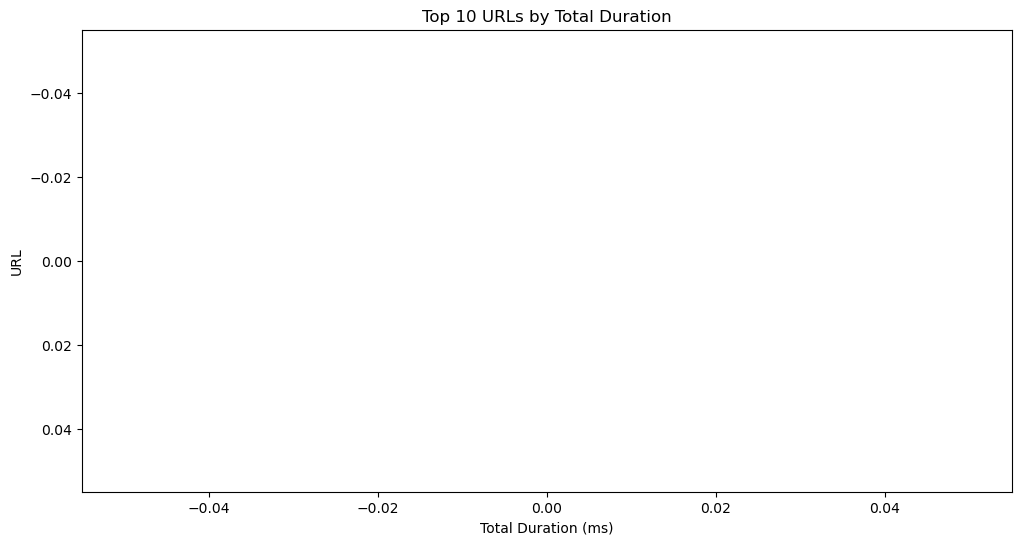

Top 10 URLs by Average Duration:
                                                  url   duration_ms
64  /socket.io/?EIO=4&transport=polling&t=PLgs4H8....  25013.495739
45                                /api?page=0&count=0    730.079860
41                                       /api/widgets    579.193771
0                                                   /    556.503178
48                 /ehrbase/rest/openehr/v1/query/aql    500.221308
9   /api/forms/visits?encounterId=4cbdee18-c2a5-5b...    392.091554
1   /__data.json?x-sveltekit-trailing-slash=1&x-sv...    358.714091
40  /api/userform?patient=daf53142-8a3a-5958-925b-...    286.992154
19  /api/forms/visits?encounterId=f5200a38-db87-5b...    282.355150
49                                              /fhir    267.478658


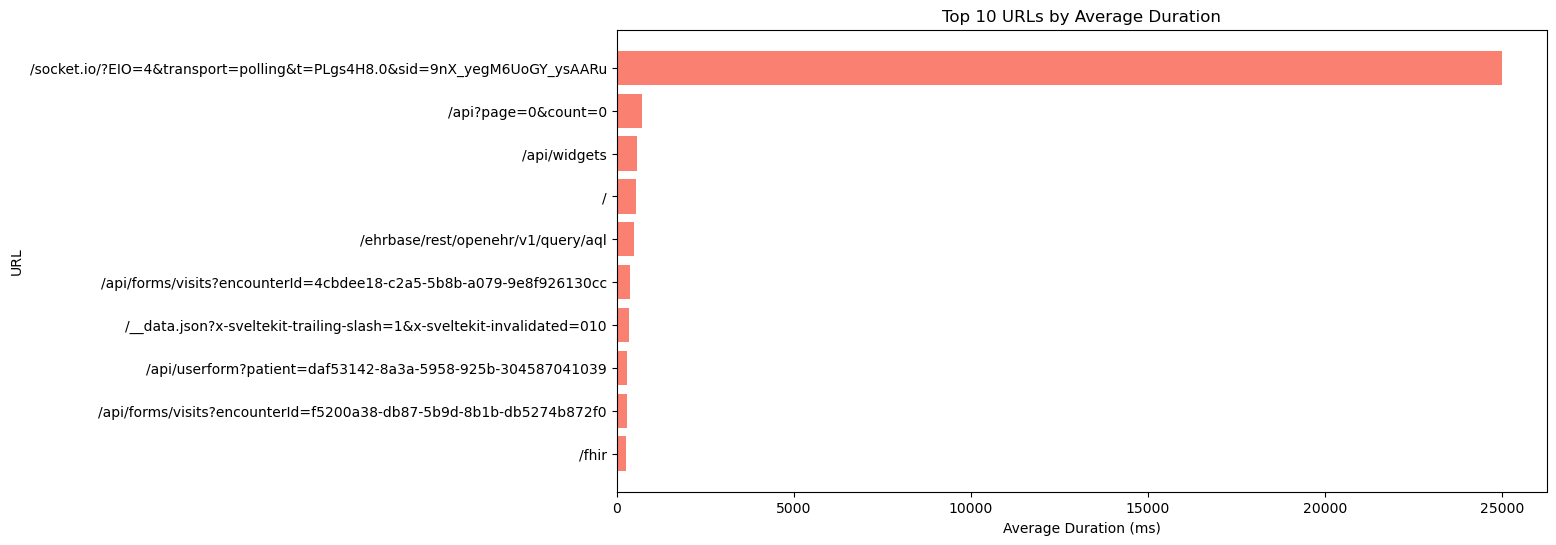

Top 10 Slowest SQL Queries by Average Duration:
                                          db_statement  duration_ms
75   select count(*) as "total" from "encounter" wh...   542.183764
74   select count(*) as "total" from "encounter" wh...   541.962784
107  select count(*) as "total" from "encounter" wh...    68.810152
91   select count(*) as "total" from "encounter" wh...    68.651664
92   select count(*) as "total" from "encounter" wh...    20.136763
76   select count(*) as "total" from "encounter" wh...    19.993100
103  select count(*) as "total" from "encounter" wh...    17.376450
87   select count(*) as "total" from "encounter" wh...    17.222842
98   select count(*) as "total" from "encounter" wh...    17.214373
105  select count(*) as "total" from "encounter" wh...    17.118847


c:\Users\kshri\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


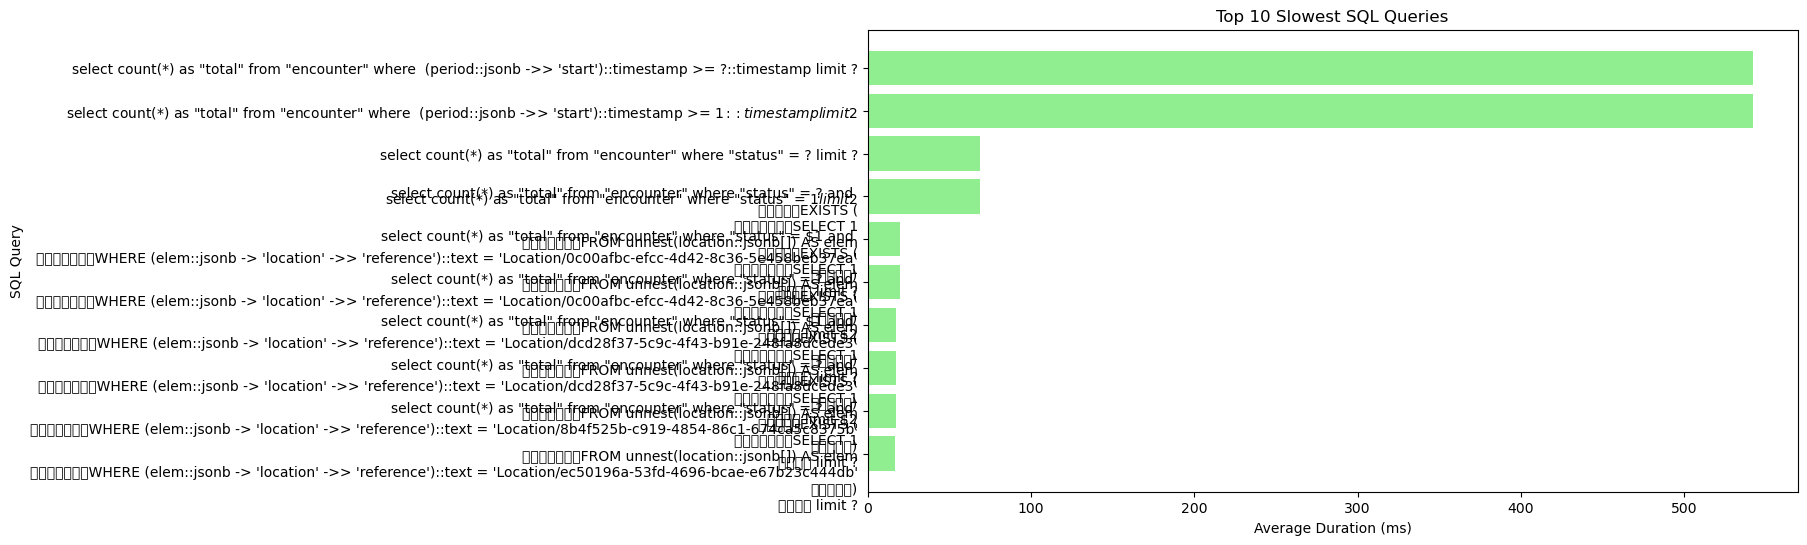

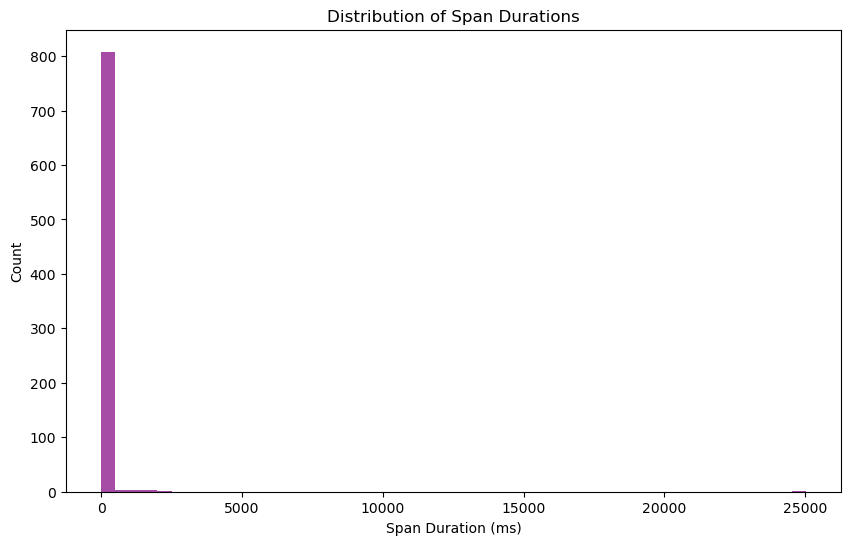

No spans with service information found.


In [14]:
# Cell 5: Data Analysis and Visualization

# Filter for spans with non-zero duration
df_nonzero = all_spans_df[all_spans_df['duration_ms'] > 0]

if df_nonzero.empty:
    print("No spans with non-zero duration found. You may need to collect more data.")
else:
    # A. Top URLs & Services by Total Duration
    url_service_agg = df_nonzero.groupby(['url', 'service'])['duration_ms'].sum().reset_index()
    top_url_service = url_service_agg.sort_values(by='duration_ms', ascending=False).head(10)
    print("Top 10 URLs & Services by Total Duration:")
    print(top_url_service)
    
    plt.figure(figsize=(12,6))
    plt.barh(top_url_service['url'], top_url_service['duration_ms'], color='skyblue')
    plt.xlabel("Total Duration (ms)")
    plt.ylabel("URL")
    plt.title("Top 10 URLs by Total Duration")
    plt.gca().invert_yaxis()  # Highest durations on top
    plt.show()
    
    # B. Average Request Time per URL
    url_avg = df_nonzero.groupby('url')['duration_ms'].mean().reset_index()
    top_url_avg = url_avg.sort_values(by='duration_ms', ascending=False).head(10)
    print("Top 10 URLs by Average Duration:")
    print(top_url_avg)
    
    plt.figure(figsize=(12,6))
    plt.barh(top_url_avg['url'], top_url_avg['duration_ms'], color='salmon')
    plt.xlabel("Average Duration (ms)")
    plt.ylabel("URL")
    plt.title("Top 10 URLs by Average Duration")
    plt.gca().invert_yaxis()
    plt.show()
    
    # C. Slowest SQL Queries (if available)
    sql_df = df_nonzero[df_nonzero['db_statement'].notnull()]
    if sql_df.empty:
        print("No SQL queries found in the data.")
    else:
        sql_avg = sql_df.groupby('db_statement')['duration_ms'].mean().reset_index()
        top_sql_avg = sql_avg.sort_values(by='duration_ms', ascending=False).head(10)
        print("Top 10 Slowest SQL Queries by Average Duration:")
        print(top_sql_avg)
        
        plt.figure(figsize=(12,6))
        plt.barh(top_sql_avg['db_statement'], top_sql_avg['duration_ms'], color='lightgreen')
        plt.xlabel("Average Duration (ms)")
        plt.ylabel("SQL Query")
        plt.title("Top 10 Slowest SQL Queries")
        plt.gca().invert_yaxis()
        plt.show()
    
    # D. Additional Analysis: Histogram of Span Durations
    plt.figure(figsize=(10,6))
    plt.hist(df_nonzero['duration_ms'], bins=50, color='purple', alpha=0.7)
    plt.xlabel("Span Duration (ms)")
    plt.ylabel("Count")
    plt.title("Distribution of Span Durations")
    plt.show()
    
    # E. Top Services by Total Duration
    service_df = df_nonzero[df_nonzero['service'].notnull()]
    if service_df.empty:
        print("No spans with service information found.")
    else:
        service_agg = service_df.groupby('service')['duration_ms'].sum().reset_index()
        top_services = service_agg.sort_values(by='duration_ms', ascending=False).head(10)
        print("Top 10 Services by Total Duration:")
        print(top_services)
        
        plt.figure(figsize=(12,6))
        plt.barh(top_services['service'], top_services['duration_ms'], color='orange')
        plt.xlabel("Total Duration (ms)")
        plt.ylabel("Service")
        plt.title("Top 10 Services by Total Duration")
        plt.gca().invert_yaxis()
        plt.show()


In [16]:
# Print the shape and columns of df_nonzero
print("df_nonzero shape:", df_nonzero.shape)
print("df_nonzero columns:", df_nonzero.columns)

# See how many unique services exist
print("Unique service values:", df_nonzero['service'].unique())

# Preview a few rows
df_nonzero.head(10)


df_nonzero shape: (822, 6)
df_nonzero columns: Index(['trace_id', 'span_id', 'service', 'url', 'db_statement', 'duration_ms'], dtype='object')
Unique service values: [None]


,trace_id,span_id,service,url,db_statement,duration_ms
0,366d87acae686ee56317eda9c883600,jqMs3LDYXtw=,None,/socket.io/?EIO=4&transport=polling&t=PLh1e-U&...,None,1.378743
1,207676803898ed03771b46d1aea385c,Qfcm2KGOtfU=,None,/v1/graphql,None,25.009782
2,207676803898ed03771b46d1aea385c,3+OTIGmMnH8=,None,/api/forms/visits?encounterId=398b9608-ff32-40...,None,39.876499
3,207676803898ed03771b46d1aea385c,UB1TGxeQ0eU=,None,None,None,2.539708
4,207676803898ed03771b46d1aea385c,aLABEbUgbPg=,None,None,None,3.148257
5,2b06b81cc90dfff17e947b360a99b77,TyZ1WefFTLw=,None,None,None,21.235185
6,2b06b81cc90dfff17e947b360a99b77,FVd2svaEPNU=,None,None,None,49.213181
7,2b06b81cc90dfff17e947b360a99b77,xW3xZIlkTlk=,None,/v1/graphql,None,135.610418
8,2b06b81cc90dfff17e947b360a99b77,88b/ITGnggg=,None,/api/forms/visits?encounterId=8da797ba-940f-57...,None,158.296442
9,6f94467c6f9ab74ebc3e651a6bec51,nrH4fHK+SqI=,None,None,None,9.800172


In [17]:
# If df_nonzero is empty, let's see how many total spans we had before filtering
print("all_spans_df shape:", all_spans_df.shape)
print(all_spans_df['duration_ms'].describe())

# Count how many have duration_ms > 0
nonzero_count = (all_spans_df['duration_ms'] > 0).sum()
print(f"Number of spans with duration_ms > 0: {nonzero_count}")


all_spans_df shape: (822, 6)
count      822.000000
mean        82.476856
std        893.410008
min          0.184730
25%          3.270475
50%          8.139494
75%         26.741567
max      25013.495739
Name: duration_ms, dtype: float64
Number of spans with duration_ms > 0: 822


                                                  url   duration_ms
64  /socket.io/?EIO=4&transport=polling&t=PLgs4H8....  25013.495739
48                 /ehrbase/rest/openehr/v1/query/aql   7003.098312
41                                       /api/widgets   6950.325250
68                                        /v1/graphql   4112.108823
49                                              /fhir   3744.701208
45                                /api?page=0&count=0   2190.239579
0                                                   /   1113.006357
9   /api/forms/visits?encounterId=4cbdee18-c2a5-5b...    784.183107
40  /api/userform?patient=daf53142-8a3a-5958-925b-...    573.984308
1   /__data.json?x-sveltekit-trailing-slash=1&x-sv...    358.714091


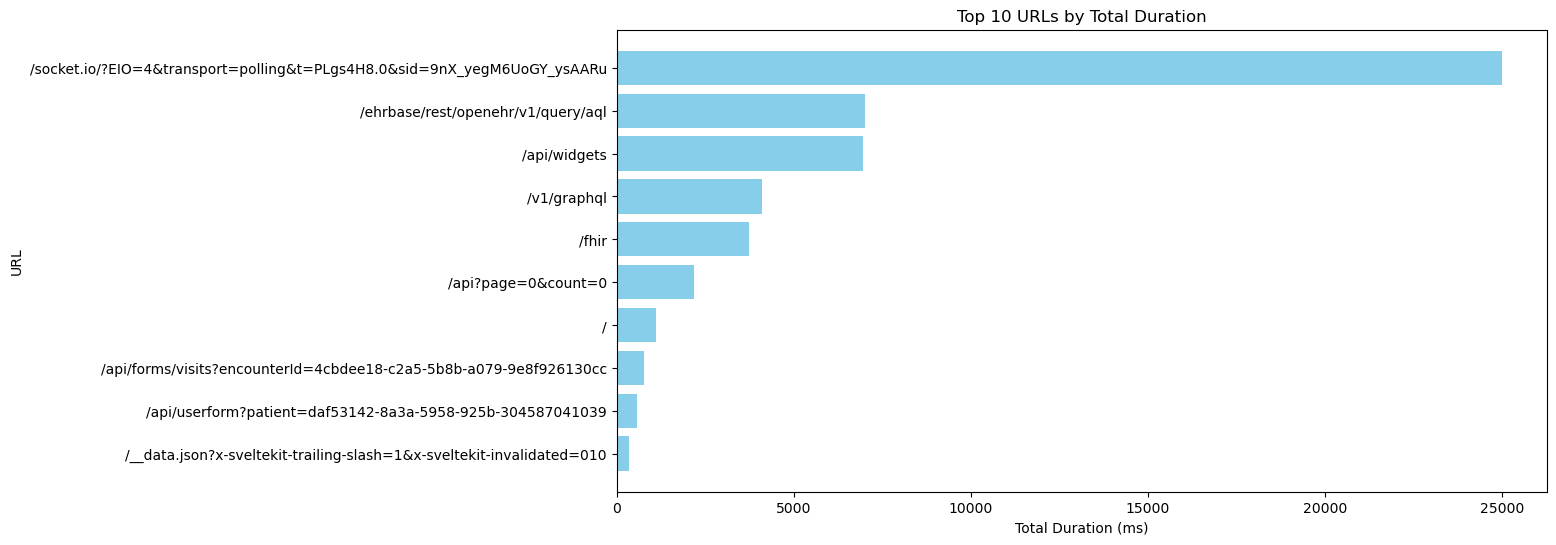

In [ ]:
df_nonzero = all_spans_df[all_spans_df['duration_ms'] > 0]

url_agg = df_nonzero.groupby('url')['duration_ms'].sum().reset_index()
top_url_agg = url_agg.sort_values(by='duration_ms', ascending=False).head(10)

print(top_url_agg)


plt.figure(figsize=(12,6))
plt.barh(top_url_agg['url'], top_url_agg['duration_ms'], color='skyblue')
plt.xlabel("Total Duration (ms)")
plt.ylabel("URL")
plt.title("Top 10 URLs by Total Duration")
plt.gca().invert_yaxis()
plt.show()


df_nonzero shape: (822, 6)
df_nonzero columns: Index(['trace_id', 'span_id', 'service', 'url', 'db_statement', 'duration_ms'], dtype='object')
Unique service values: [None]

Top 10 URLs by Total Duration:
                                                  url   duration_ms
64  /socket.io/?EIO=4&transport=polling&t=PLgs4H8....  25013.495739
48                 /ehrbase/rest/openehr/v1/query/aql   7003.098312
41                                       /api/widgets   6950.325250
68                                        /v1/graphql   4112.108823
49                                              /fhir   3744.701208
45                                /api?page=0&count=0   2190.239579
0                                                   /   1113.006357
9   /api/forms/visits?encounterId=4cbdee18-c2a5-5b...    784.183107
40  /api/userform?patient=daf53142-8a3a-5958-925b-...    573.984308
1   /__data.json?x-sveltekit-trailing-slash=1&x-sv...    358.714091


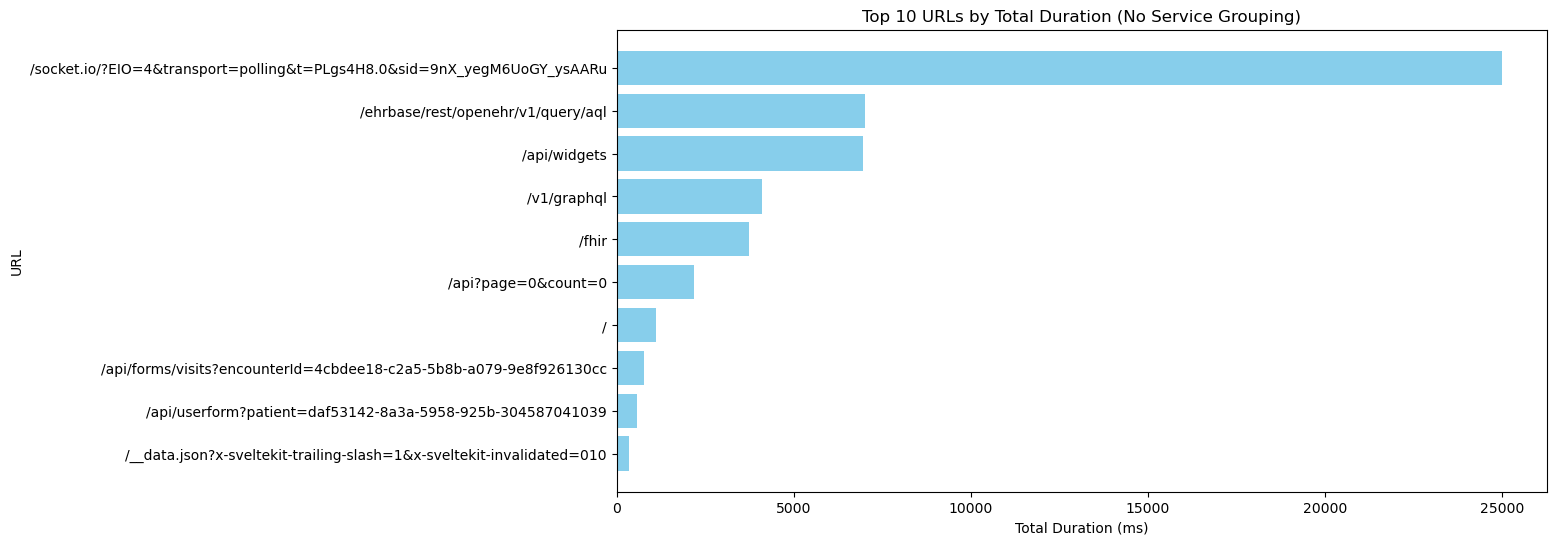


Top 10 URLs + Services by Total Duration:
                                                  url          service  \
64  /socket.io/?EIO=4&transport=polling&t=PLgs4H8....  unknown-service   
48                 /ehrbase/rest/openehr/v1/query/aql  unknown-service   
41                                       /api/widgets  unknown-service   
68                                        /v1/graphql  unknown-service   
49                                              /fhir  unknown-service   
45                                /api?page=0&count=0  unknown-service   
0                                                   /  unknown-service   
9   /api/forms/visits?encounterId=4cbdee18-c2a5-5b...  unknown-service   
40  /api/userform?patient=daf53142-8a3a-5958-925b-...  unknown-service   
1   /__data.json?x-sveltekit-trailing-slash=1&x-sv...  unknown-service   

     duration_ms  
64  25013.495739  
48   7003.098312  
41   6950.325250  
68   4112.108823  
49   3744.701208  
45   2190.239579  
0    1113

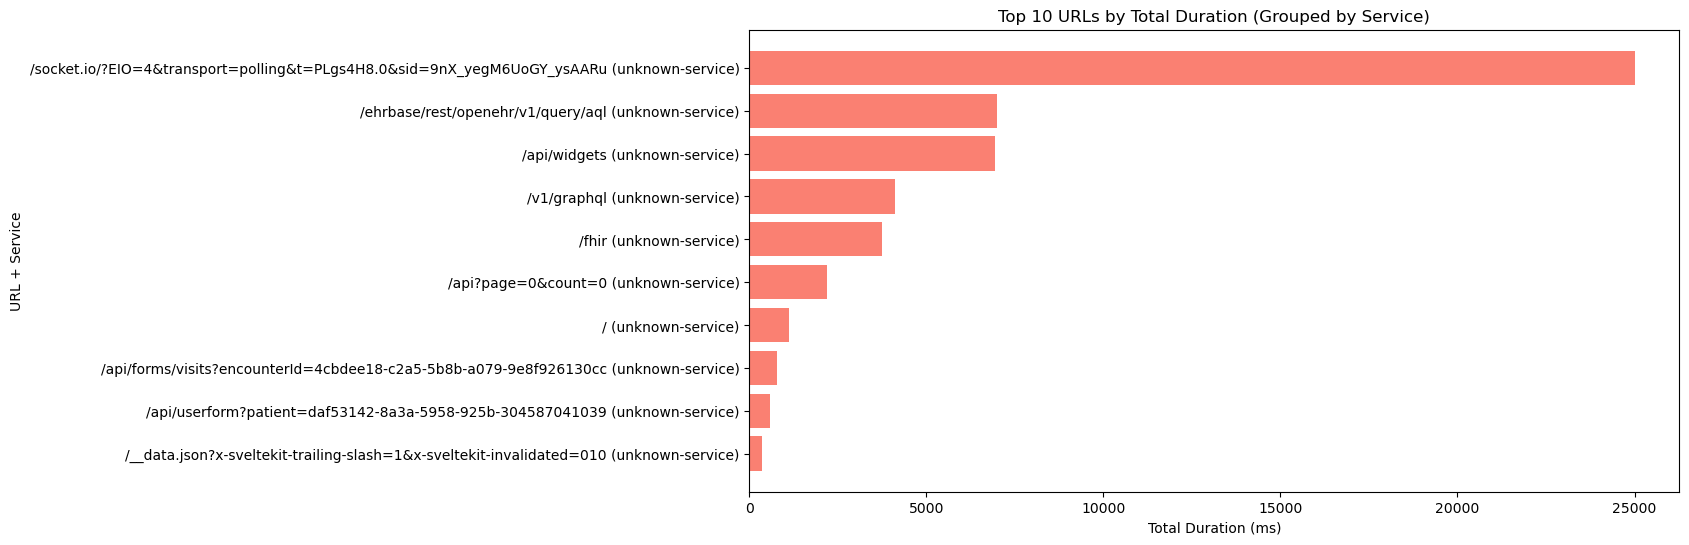

In [ ]:
# Single-cell analysis and plotting



# 1. Basic DataFrame Info
print("df_nonzero shape:", df_nonzero.shape)
print("df_nonzero columns:", df_nonzero.columns)
print("Unique service values:", df_nonzero['service'].unique())

# 2. Top 10 URLs by Total Duration
url_agg = df_nonzero.groupby('url')['duration_ms'].sum().reset_index()
top_url_agg = url_agg.sort_values(by='duration_ms', ascending=False).head(10)

print("\nTop 10 URLs by Total Duration:")
print(top_url_agg)

plt.figure(figsize=(12,6))
plt.barh(top_url_agg['url'], top_url_agg['duration_ms'], color='skyblue')
plt.xlabel("Total Duration (ms)")
plt.ylabel("URL")
plt.title("Top 10 URLs by Total Duration (No Service Grouping)")
plt.gca().invert_yaxis()
plt.show()

# 3. Grouping by URL + Service (Filling missing service with a placeholder)
df_nonzero['service'] = df_nonzero['service'].fillna('unknown-service')
url_service_agg = df_nonzero.groupby(['url', 'service'])['duration_ms'].sum().reset_index()
top_url_service = url_service_agg.sort_values(by='duration_ms', ascending=False).head(10)

print("\nTop 10 URLs + Services by Total Duration:")
print(top_url_service)

# Create combined label: "URL (service)"
labels = top_url_service['url'] + " (" + top_url_service['service'] + ")"

plt.figure(figsize=(12,6))
plt.barh(labels, top_url_service['duration_ms'], color='salmon')
plt.xlabel("Total Duration (ms)")
plt.ylabel("URL + Service")
plt.title("Top 10 URLs by Total Duration (Grouped by Service)")
plt.gca().invert_yaxis()
plt.show()


# Issue:  spans never set a service name. 

# Potential Bottlenecks

/socket.io with ~25 s total duration might be a single outlier or multiple slow calls.

/ehrbase/rest/openehr/v1/query/aql and /api/widgets also have high total durations (7 seconds and 6.95 seconds, respectively).

In [22]:
# Group by URL, compute total duration, count, and average
stats_by_url = df_nonzero.groupby('url').agg(
    total_duration=('duration_ms', 'sum'),
    count=('duration_ms', 'count'),
    avg_duration=('duration_ms', 'mean')
).reset_index()

# Sort by total_duration descending
stats_by_url = stats_by_url.sort_values('total_duration', ascending=False)

print("Stats by URL (total, count, average duration):")
print(stats_by_url.head(10))


Stats by URL (total, count, average duration):
                                                  url  total_duration  count  \
64  /socket.io/?EIO=4&transport=polling&t=PLgs4H8....    25013.495739      1   
48                 /ehrbase/rest/openehr/v1/query/aql     7003.098312     14   
41                                       /api/widgets     6950.325250     12   
68                                        /v1/graphql     4112.108823     82   
49                                              /fhir     3744.701208     14   
45                                /api?page=0&count=0     2190.239579      3   
0                                                   /     1113.006357      2   
9   /api/forms/visits?encounterId=4cbdee18-c2a5-5b...      784.183107      2   
40  /api/userform?patient=daf53142-8a3a-5958-925b-...      573.984308      2   
1   /__data.json?x-sveltekit-trailing-slash=1&x-sv...      358.714091      1   

    avg_duration  
64  25013.495739  
48    500.221308  
41    579.19377

In [23]:
socketio_df = df_nonzero[df_nonzero['url'].str.contains('/socket.io', na=False)]
print("Socket.IO spans:")
print(socketio_df.describe())

# Possibly look at the top 5 slowest calls
top_slowest_socketio = socketio_df.nlargest(5, 'duration_ms')
print("\nTop 5 slowest socket.io spans:")
print(top_slowest_socketio[['trace_id', 'span_id', 'duration_ms']])


Socket.IO spans:
        duration_ms
count     11.000000
mean    2275.847462
std     7541.225161
min        0.714108
25%        1.082339
50%        1.333390
75%        2.072721
max    25013.495739

Top 5 slowest socket.io spans:
                             trace_id       span_id   duration_ms
507   28c5742ebd80abad72f987ce7275fb7  F+cqRrRCtY4=  25013.495739
195   1fc837751ad4d948e5053bc76409953  IFo2bZpZqcw=      8.991220
658  ac1aa5cf4ddcbaa6c2f92e468363fa18  +XAg2bKbzes=      2.447361
149    bc41093b256b882ddd222cc92f53bf  e56+8f/ZwaI=      1.698081
0     366d87acae686ee56317eda9c883600  jqMs3LDYXtw=      1.378743


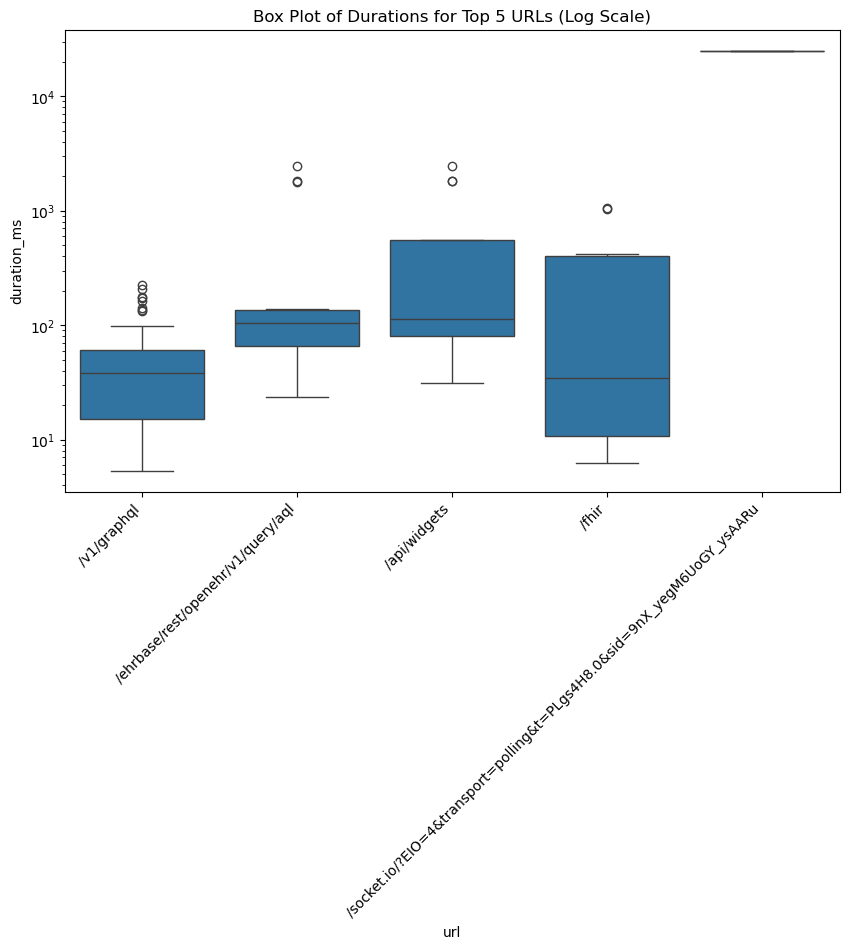

In [ ]:

# Focus on top 5 URLs by total duration
top5_urls = stats_by_url.head(5)['url']
filtered_df = df_nonzero[df_nonzero['url'].isin(top5_urls)]

plt.figure(figsize=(10,6))
sns.boxplot(x='url', y='duration_ms', data=filtered_df)

# Apply a log scale on the y-axis
plt.yscale('log')

plt.xticks(rotation=45, ha='right')
plt.title("Box Plot of Durations for Top 5 URLs (Log Scale)")
plt.show()


Understand the Single 25 Second Outlier

One Big Call vs. Many Calls: Your stats show 1 call with total = 25 s. The “count=1” for /socket.io in the aggregated table means that specific URL string was matched exactly once in that dataset. Meanwhile, you found 11 total “socket.io” spans, but they might have slightly different query parameters (e.g., sid, t, etc.), causing them to appear as different URLs in your grouping. 

Investigate That Single Span:
Look up its trace_id (28c5742ebd80abad72f987ce7275fb7 in your snippet).
Fetch the full trace from Tempo (/api/traces/{trace_id}) to see why it took 25 s. Possibly a timeout, a long-polling connection, or a stuck operation.

to do after

/ehrbase/rest/openehr/v1/query/aql: 14 calls total ~7 s → ~500 ms each.
If 500 ms is normal for your queries, that might be acceptable—or it might be slow if you expect 100 ms.

/api/widgets: 12 calls total ~6.95 s → ~580 ms each. Similar question: is half a second acceptable for “widgets”?

In [25]:
aql_df = df_nonzero[df_nonzero['url'].str.contains('/ehrbase/rest/openehr/v1/query/aql', na=False)]
print(aql_df.describe())

widgets_df = df_nonzero[df_nonzero['url'] == '/api/widgets']
print(widgets_df.describe())


       duration_ms
count    14.000000
mean    500.221308
std     838.108740
min      23.503955
25%      66.313211
50%     104.790300
75%     136.514879
max    2444.781213
       duration_ms
count    12.000000
mean    579.193771
std     888.148574
min      31.381132
25%      81.194269
50%     113.105107
75%     557.921700
max    2451.684619


# SUMMARY


# Top 10 URLs by Total Duration

                                                  url   duration_ms
64  /socket.io/?EIO=4&transport=polling&t=PLgs4H8....  25013.495739
48                 /ehrbase/rest/openehr/v1/query/aql   7003.098312
41                                       /api/widgets   6950.325250
68                                        /v1/graphql   4112.108823
49                                              /fhir   3744.701208
45                                /api?page=0&count=0   2190.239579
0                                                   /   1113.006357
9   /api/forms/visits?encounterId=4cbdee18-c2a5-5b...    784.183107
40  /api/userform?patient=daf53142-8a3a-5958-925b-...    573.984308
1   /__data.json?x-sveltekit-trailing-slash=1&x-sv...    358.714091


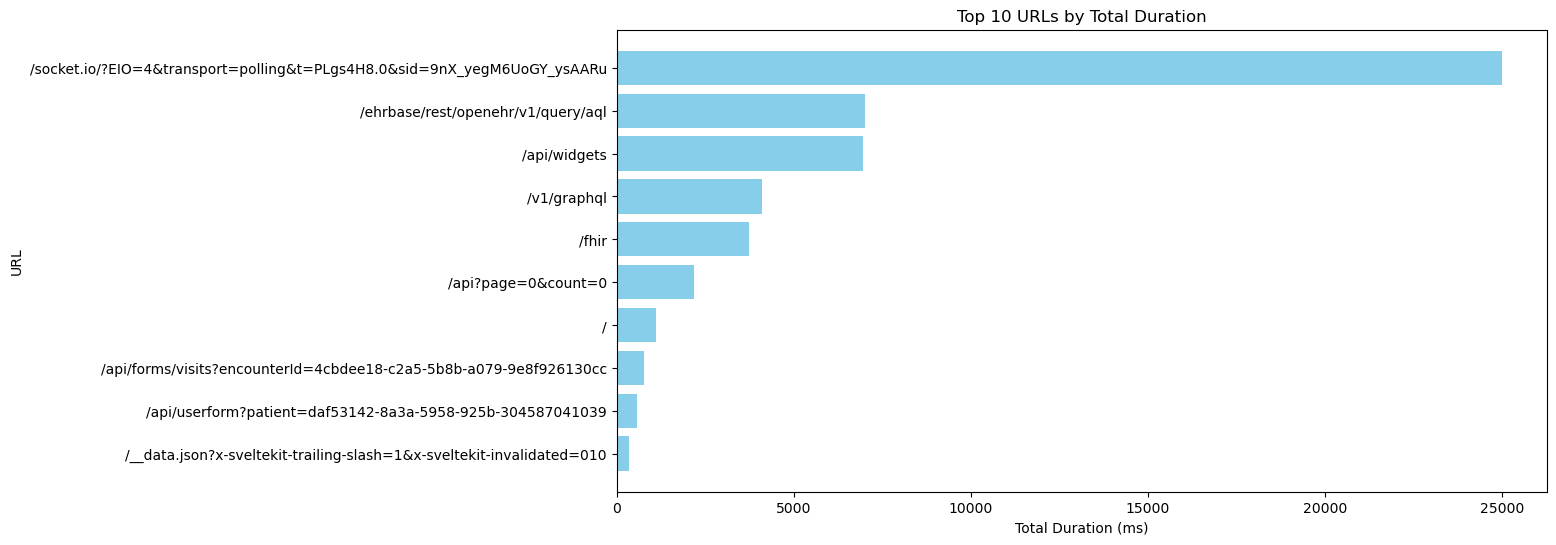

In [ ]:
df_nonzero = all_spans_df[all_spans_df['duration_ms'] > 0]

url_agg = df_nonzero.groupby('url')['duration_ms'].sum().reset_index()
top_url_agg = url_agg.sort_values(by='duration_ms', ascending=False).head(10)

print(top_url_agg)


plt.figure(figsize=(12,6))
plt.barh(top_url_agg['url'], top_url_agg['duration_ms'], color='skyblue')
plt.xlabel("Total Duration (ms)")
plt.ylabel("URL")
plt.title("Top 10 URLs by Total Duration")
plt.gca().invert_yaxis()
plt.show()

C:\Users\kshri\AppData\Local\Temp\ipykernel_20100\2517955704.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


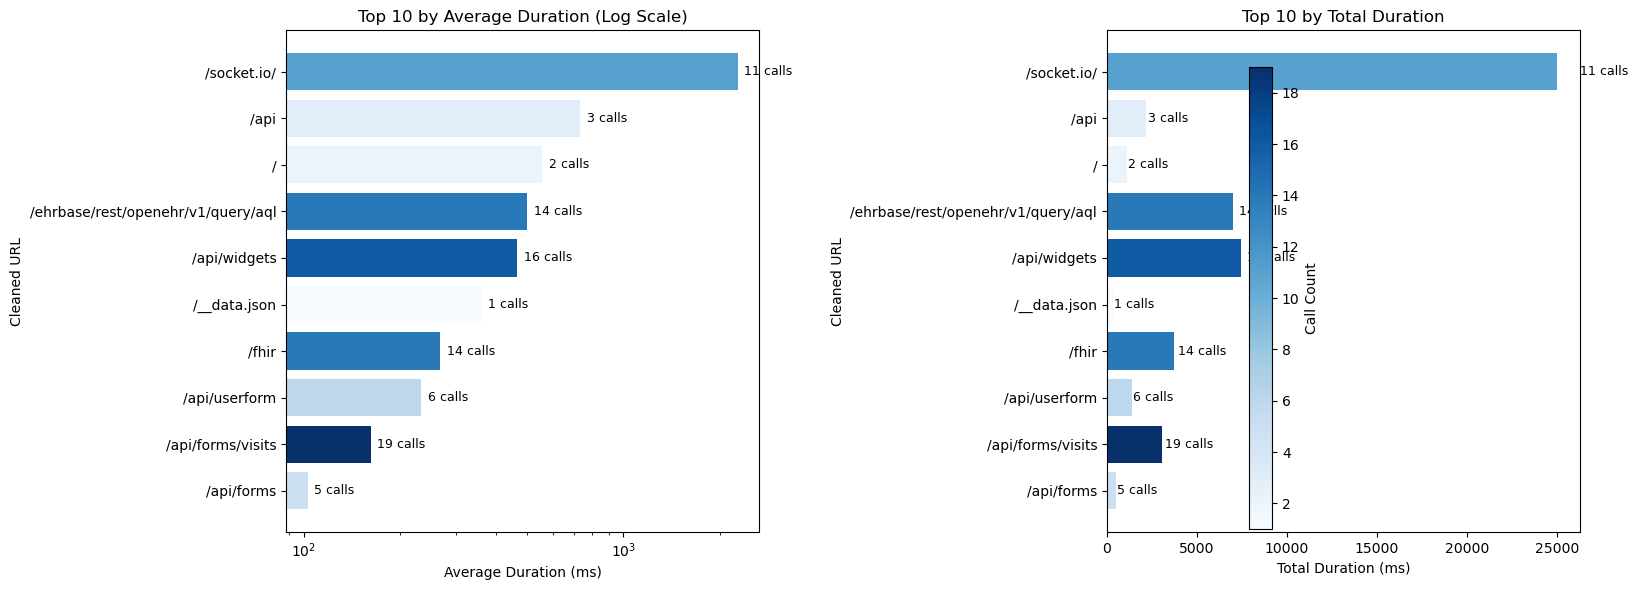

In [ ]:


# -------------------------------------------------------------
Create a helper function to strip query parameters
# -------------------------------------------------------------
def strip_query_params(url):
    if not isinstance(url, str):
        return url
    return url.split('?')[0]

# -------------------------------------------------------------
# Apply the cleaning logic to create a "clean_url" column
#    and aggregate stats by "clean_url"
# -------------------------------------------------------------
df_nonzero['clean_url'] = df_nonzero['url'].apply(strip_query_params)

stats_by_clean_url = df_nonzero.groupby('clean_url').agg(
    total_duration=('duration_ms', 'sum'),
    count=('duration_ms', 'count'),
    avg_duration=('duration_ms', 'mean')
).reset_index()

# Sort by average duration descending
stats_by_clean_url = stats_by_clean_url.sort_values('avg_duration', ascending=False)

# Pick top 10
top10 = stats_by_clean_url.head(10)

# -------------------------------------------------------------
# 3. Prepare color mapping based on call count
#  color each bar according to how many calls occurred.
# -------------------------------------------------------------
counts = top10['count'].values
norm = mcolors.Normalize(vmin=counts.min(), vmax=counts.max())
cmap = cm.Blues
colors = [cmap(norm(c)) for c in counts]

# -------------------------------------------------------------
# 4. Create a figure with two subplots side-by-side
# -------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,6))

# -------------------------------------------------------------
# 4A. Left subplot: Average Duration (log scale)
# -------------------------------------------------------------
bars1 = ax1.barh(top10['clean_url'], top10['avg_duration'], color=colors)
ax1.set_xlabel("Average Duration (ms)")
ax1.set_ylabel("Cleaned URL")
ax1.set_title("Top 10 by Average Duration (Log Scale)")
ax1.invert_yaxis()  # largest bar on top
ax1.set_xscale('log')  # log scale to handle large outliers

# Label each bar with call count
for i, bar in enumerate(bars1):
    cnt = int(top10.iloc[i]['count'])
    label_x = bar.get_width()  # bar length
    label_y = bar.get_y() + bar.get_height() / 2
    ax1.text(label_x*1.05, label_y, f"{cnt} calls", va='center', fontsize=9)

# -------------------------------------------------------------
# 4B. Right subplot: Total Duration (linear scale)
# -------------------------------------------------------------
bars2 = ax2.barh(top10['clean_url'], top10['total_duration'], color=colors)
ax2.set_xlabel("Total Duration (ms)")
ax2.set_ylabel("Cleaned URL")
ax2.set_title("Top 10 by Total Duration")
ax2.invert_yaxis()  # largest bar on top

# Label each bar with call count
for i, bar in enumerate(bars2):
    cnt = int(top10.iloc[i]['count'])
    label_x = bar.get_width()  # bar length
    label_y = bar.get_y() + bar.get_height() / 2
    ax2.text(label_x*1.05, label_y, f"{cnt} calls", va='center', fontsize=9)

# -------------------------------------------------------------
# 5. Add a colorbar legend to indicate call count
# -------------------------------------------------------------
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # required for matplotlib < 3.2
cbar = fig.colorbar(sm, ax=[ax1, ax2], label='Call Count')

plt.tight_layout()
plt.show()


# Top 10 Slowest SQL Queries by Average Duration

C:\Users\kshri\AppData\Local\Temp\ipykernel_20100\3693636307.py:63: UserWarning: Glyph 9 (	) missing from current font.
  plt.tight_layout()
c:\Users\kshri\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


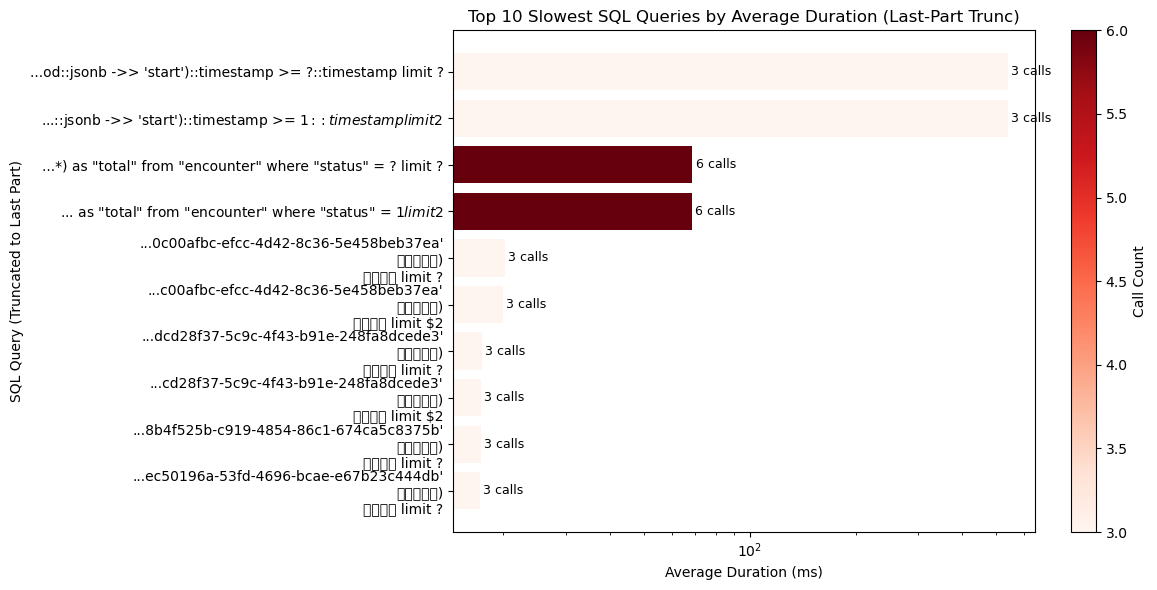

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm


def truncate_sql_end(sql, max_len=60):
    """
    Truncate the SQL statement to show the last `max_len` characters.
    If it's shorter than `max_len`, return the full statement.
    """
    sql_str = str(sql)
    if len(sql_str) <= max_len:
        return sql_str
    else:
        # '...' + last (max_len-3) characters
        return "..." + sql_str[-(max_len - 3):]

# 1) Create a truncated version of each query
stats_by_query['trunc_sql'] = stats_by_query['db_statement'].apply(truncate_sql_end)

# 2) Sort by average duration (descending) and pick top 10
stats_by_query = stats_by_query.sort_values('avg_duration', ascending=False).head(10)

# 3) Prepare color mapping based on call count
counts = stats_by_query['count'].values
norm = mcolors.Normalize(vmin=counts.min(), vmax=counts.max())
cmap = cm.Reds
colors = [cmap(norm(c)) for c in counts]

# 4) Create a horizontal bar chart using truncated SQL
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(stats_by_query['trunc_sql'], stats_by_query['avg_duration'], color=colors)

ax.set_xlabel("Average Duration (ms)")
ax.set_ylabel("SQL Query (Truncated to Last Part)")
ax.set_title("Top 10 Slowest SQL Queries by Average Duration (Last-Part Trunc)")

# Flip the y-axis so the largest bar is on top
ax.invert_yaxis()

# 5) Label each bar with the call count
for i, bar in enumerate(bars):
    cnt = int(stats_by_query.iloc[i]['count'])
    label_x = bar.get_width()  # bar length
    label_y = bar.get_y() + bar.get_height() / 2
    ax.text(label_x * 1.02, label_y, f"{cnt} calls", va='center', fontsize=9)

# 6) Add a colorbar legend to indicate call count
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label='Call Count')
ax.set_xscale('log')

plt.tight_layout()
plt.show()


In [33]:
# work to be done to make this readable

# Box Plot of Durations for Top 5 URLs (Log Scale)

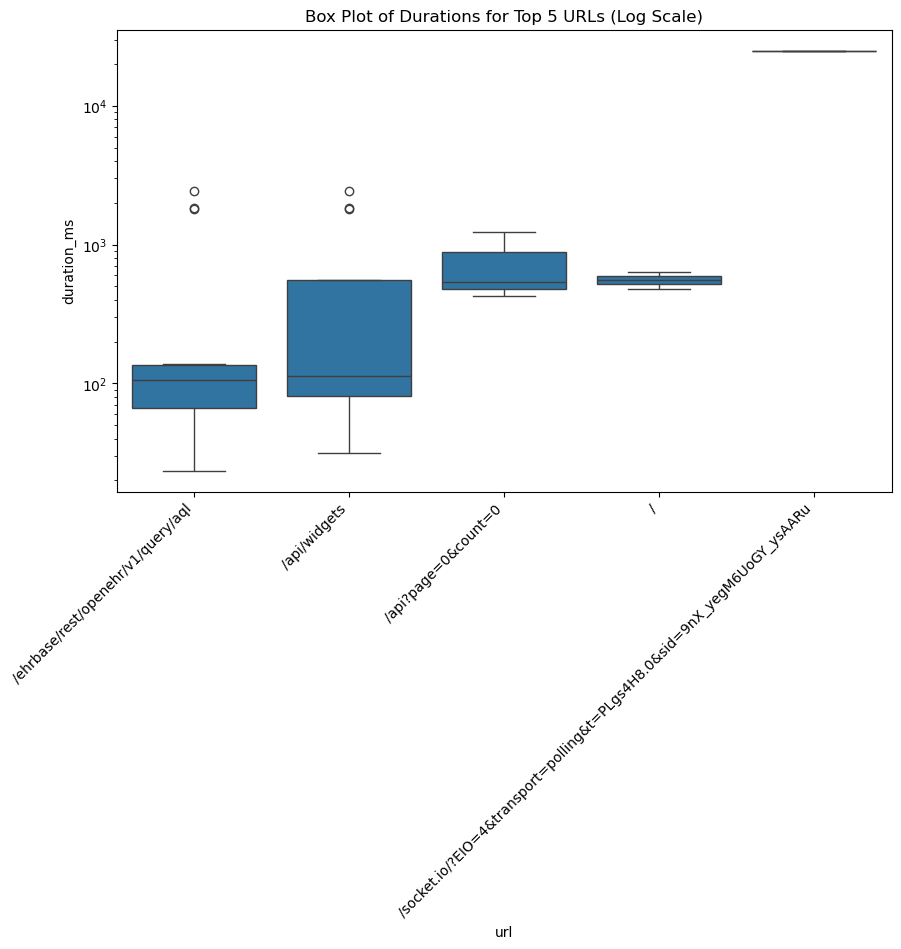

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Focus on top 5 URLs by total duration
top5_urls = stats_by_url.head(5)['url']
filtered_df = df_nonzero[df_nonzero['url'].isin(top5_urls)]

plt.figure(figsize=(10,6))
sns.boxplot(x='url', y='duration_ms', data=filtered_df)

# Apply a log scale on the y-axis
plt.yscale('log')

plt.xticks(rotation=45, ha='right')
plt.title("Box Plot of Durations for Top 5 URLs (Log Scale)")
plt.show()

To interpret the box plot of durations for the top 5 URLs (log scale), follow these steps:

1. **Axes**:
    - The x-axis represents the duration of spans in milliseconds (ms).
    - The y-axis lists the top 5 URLs.

2. **Box Plot Components**:
    - **Box**: The central box represents the interquartile range (IQR), which contains the middle 50% of the data.
    - **Median Line**: The line inside the box indicates the median duration.
    - **Whiskers**: The lines extending from the box show the range of the data, excluding outliers.
    - **Outliers**: Points outside the whiskers are considered outliers and are plotted individually.

3. **Log Scale**:
    - The y-axis is on a logarithmic scale, which helps to visualize data with a wide range of values more effectively. This is particularly useful when there are large outliers.

4. **Interpretation**:
    - **/socket.io/**: This URL has a very high median duration and a wide range of durations, indicating significant variability. The presence of outliers suggests occasional very long durations.
    - **/api?page=0&count=0**: This URL has a moderate median duration with a relatively narrow IQR, indicating more consistent performance. However, there are still some outliers.
    - **/api/widgets**: This URL shows a high median duration with a wide IQR, indicating variability. There are also several outliers.
    - **/**: This URL has a lower median duration compared to the others, with a narrow IQR, indicating consistent performance.
    - **/ehrbase/rest/openehr/v1/query/aql**: This URL has a moderate median duration with a wide IQR, indicating variability. There are also several outliers.

Overall, the box plot helps identify URLs with high variability and potential performance issues, as well as those with more consistent performance. The log scale allows for better visualization of the differences in duration across URLs.